In [ ]:
import re
import zlib
import base64
import datetime
import numpy as np
import pandas as pd
import json
import configparser
from utils import *
from sys import platform
from elasticsearch import Elasticsearch

In [ ]:
cf = configparser.ConfigParser()
cf.read('config/config.cfg')

env = 'DEVELOP'
if 'win' in platform:
    env = 'DEVELOP'
elif 'linux' in platform:
    env = 'PRODUCT'
    
class EsCtrl(object):
    def __init__(self):
        self.es_ctrl = Elasticsearch(cf['ENV_'+env]['ADDR'], ca_certs=cf['ELASTICSEARCH']['CA_CERTS'])

    def query_index_logs(self, index):
        # query = {
        #     "match": {
        #         "trace": "com_ericsson_trithread:INFO"
        #     }
        # }
        #data = self.es_ctrl.search(index=index, query=query, scroll='1s', size=10000)
        data = self.es_ctrl.search(index=index, scroll='1s', size=10000)
        sid = data['_scroll_id']
        scroll_size = len(data['hits']['hits'])
        res = []
        while scroll_size > 0:
            # Before scroll, process current batch of hits
            res.extend(data['hits']['hits'])
            data = self.es_ctrl.scroll(scroll_id=sid, scroll='1s')
            # Update the scroll ID
            sid = data['_scroll_id']
            # Get the number of results that returned in the last scroll
            scroll_size = len(data['hits']['hits'])
        return res

    def query_indices(self):
        res = []
        for key in self.es_ctrl.indices.get_alias().keys():
            if len(key) > 0:
                if '.analyzed_' in key:
                    res.append(key.replace('.analyzed_', ''))
        return res

    def is_exists(self, index):
        return self.es_ctrl.indices.exists(index=index)

    def count_index(self, index):
        return self.es_ctrl.count(index=index)['count']

    def store_index(self, index, data):
        data = deflate_and_base64_encode(json.dumps(data).encode('utf-8'))
        return self.es_ctrl.index(index=index, body={'content': data})

    def query_index(self, index):
        data = self.es_ctrl.search(index=index)
        data = json.loads(decode_base64_and_inflate(data['hits']['hits'][0]['_source']['content']))
        return data

In [ ]:
# 1.值范围 2.相似线段形态 3.highlight落在区间内 4.方差大

In [ ]:
import json
import uuid
branch = ['A','B','C','D','E','F','G','H','I','J','K','L']
config = {'search':[], 'insight':[], 'chart':[], 'statistic':[]}
for index in range(12):
    item = {}
    item['alias'] = 'search_branch' + str(branch[index])
    item['desc'] = 'Branch ' + str(branch[index]) + ' common use KeyValue and Mark'
    item['exp_search'] = '(txlProcBranch'+str(branch[index])+'|TxBranchCtrl'+str(branch[index])+').*(txAtt|linearization fault|external fault)'
    item['exp_extract'] = [
                        "{}[{timestamp:ti}] {}txAtt:{txAtt:d}, {}torTemperature:{torTemperature:d} {}avgIMpa0:{avgIMpa0:d} {}",
                        "{}[{timestamp:ti}] {}"
                        ]
    item['exp_mark'] = [{"alias":"LF","exp":"linearization fault","color":"#f00000"}]
    item['is_case_sensitive'] = True
    item['forward_rows'] = 0
    item['backward_rows'] = 0
    config['search'].append(item)

# for index in range(12):
#     item = {}
#     item['alias'] = 'insight_branch' + str(branch[index])
#     item['desc'] = 'Branch Insight' + str(branch[index])
#     item['exp_search'] = '(txlProcBranch'+str(branch[index])+'|TxBranchCtrl'+str(branch[index])+')'
#     item['exp_extract'] = "{}[{timestamp:ti}]{}, msg = {msg}"
#     item['exp_mark'] = {"alias":"LF","exp":"linearization fault","color":"#f00000"}
#     item['is_case_sensitive'] = True
#     item['forward_rows'] = 0
#     item['backward_rows'] = 0
#     config['insight'].append(item)
    
# config['statistic'] = [
#     {'alias': 'test1', 'desc': 'BranchA txatt', 'code': "self.result = self.text_analysis_model.alias_data['search_branchA'].res_key_value['txAtt']['global_index']"},
#     {'alias': 'test2', 'desc': 'BranchB txatt', 'code': "self.result = self.text_analysis_model.alias_data['search_branchB'].res_key_value['txAtt']['global_index']"},
# ]
    
json_object = json.dumps(config)
with open("E:\\projects\\ericsson_flow\\new_files\\config.txt", "w") as outfile:
    outfile.write(json_object)

In [ ]:
import re
from parse import parse

str1 = 'BXP_3: [2022-11-23 22:04:44.572174570] (+0.000333470) radio6626 com_ericsson_trithread:INFO: { cpu_id = 1 }, { process = "txlProcBranchB", fileAndLine = "dpdController.cc:1887", msg = "txAtt:289, txAttPeak:0, dpGainLoopEnable:true, dpGainCtrlType:DSA_AD_TXFE, torTemperature:495 (0.1C), torGainBackoff:0 (0.01dB), torGainLin:3.49543(0.01dB), torStepBit:6, cc0Ctrl1=0x00000118 , avgIMpa0:1980 [mAmp]" }'
str2 = 'BXP_3: [2022-12-10 15:55:26.739019220] (+0.000025340) radio6626 com_ericsson_trithread:INFO: { cpu_id = 1 }, { process = "TxBranchCtrlB", fileAndLine = "txChangeCycleHelper.cc:264", msg = "Txl branch J restart due to txL linearization fault!" }'
# str1 = "BXP_2: [221120 164014] 27: PA measured values for driver name: DpaVddSv:7; value: 26992; branch Id: 7"
# exp = "\[%{TIMESTAMP:time}\] \(%{STRING:cost}\) "
# exp = "\[%{TIMESTAMP:time}\] %{DROP:tmp}Pma:%{FLOAT:Pma0}\[%{DROP:tmp1}DpdPma:%{FLOAT:DpdPma0}\[%{DROP:tmp2}Pmb:%{FLOAT:Pmb}, TorPmb:%{FLOAT:TorPmb0}\[%{FLOAT:TorPmb1} %{FLOAT:TorPmb2}\] "
exp_search = '(txlProcBranchB|TxBranchCtrlB).*(txAtt|linearization fault)'
exp_extract = '{}[{timestamp:ti}] {}txAtt:{txAtt:d}, {}torTemperature:{torTemperature:d} {}avgIMpa0:{avgIMpa0:d} {}'
r_search = re.findall(exp_search, str1)
r_extract = parse(exp_extract, str1)
print(r_search)
print(r_extract.named)

In [ ]:
aaa = 111
class A():
    def __init__(self, data):
        self.a = 1
        self.b = 2
        self.__dict__.update(data)
        
    def test(self, num):
#         aaa = 222
        print(aaa)

class B(A):
    def __init__(self):
        super().__init__()
        self.c = 3
        self.d = {'ins': ''}
        
a = A({'a':3, 'b':4})
# b = B()
# data = {'a':a, 'b':b}

In [ ]:
class A:
    def __init__(self):
        self.a = 1

class B(A):
    def __init__(self):
        super().__init__()
        self.b = 2
        self.c = C()

        
    def set_attr(self):
        exec("self.a['a']['b']['c'] = 'aaa'")
        
class C():
    def __init__(self):
        self.c = 3

c = B()
c.a = {'a':{'b':{'c':'foo', 'e':12 , 'f':True}}}

b = B()
b.a = {'a':{'b':{'c':42, 'd':33, 'f':False}}}
b.b = 3

In [ ]:
from deepdiff import DeepDiff

item1 = {'a':{'b':{'c':'foo', 'e':12 , 'f':True}}}
item2 = {'a':{'b':{'c':42, 'd':33, 'f':False}}}
DeepDiff(item1, item2)

In [ ]:
DeepDiff(c.a, b.a)

In [1]:
import re
import json
from text_analysis import TextAnalysisModel

text_analysis_model = await TextAnalysisModel('parallel', mode = 'test')

file_path = ['E:\\Projects\\ericsson_flow\\new_files\\E55H047512_LTE_CIBEUREUM_CBN2_PL_BXP_5_telog.log']
config_path = 'E:\\Projects\\ericsson_flow\\new_files\\config2.txt'
config = [config_path, json.dumps(json.load(open(config_path)))]

await text_analysis_model.file_container_model.on_new_file('', file_path)
await text_analysis_model.file_container_model.on_load_config('', config)

for key in text_analysis_model.alias_data.keys():
    print(key, len(text_analysis_model.alias_data[key].outlier))

C:\Users\LDJ\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


insight_branchA 167
insight_branchB 0
insight_branchC 0
insight_branchD 0
insight_branchE 0
insight_branchF 0
insight_branchG 0
insight_branchH 0
insight_branchI 141
insight_branchJ 0
insight_branchK 0
insight_branchL 155


In [2]:
for index, item in enumerate(text_analysis_model.alias_data['insight_branchA'].outlier):
    if item['abnormal_type'] == 'Mutation':
        print(index, item['timestamp'], item['desc'], re.findall('msg = "(.*?)"', item['origin']))

3 2022-12-29 12:59:53.446677 RUEV:  LTU_UNLOCKED --> LTU_LOCKED ['RUEV:LTU_LOCKED 79845138us txBranchId=0']
5 2022-12-29 13:00:01.532712 event:  EVENT_SETUP --> Undefined ['New event= Undefined event type 5 carrierId= 812 fbsId= 2 fbsState= SETUP cycleRequired= NO 0']
7 2022-12-29 13:00:05.641436 event:  Undefined --> EVENT_RELEASE ['New event= EVENT_RELEASE carrierId= 812 fbsId= 2 fbsState= RELEASING cycleRequired= YES 220']
8 2022-12-29 13:00:05.641436 fbsState:  SETUP --> RELEASING ['New event= EVENT_RELEASE carrierId= 812 fbsId= 2 fbsState= RELEASING cycleRequired= YES 220']
9 2022-12-29 13:00:05.641436 cycleRequired:  NO --> YES ['New event= EVENT_RELEASE carrierId= 812 fbsId= 2 fbsState= RELEASING cycleRequired= YES 220']
12 2022-12-29 13:00:06.596962 event:  EVENT_RELEASE --> EVENT_SETUP ['New event= EVENT_SETUP carrierId= 812 fbsId= 1 fbsState= SETUP cycleRequired= NO 0']
13 2022-12-29 13:00:06.596962 fbsState:  RELEASING --> SETUP ['New event= EVENT_SETUP carrierId= 812 fbsId=

In [5]:
text_analysis_model.alias_data['insight_branchA'].res_key_value['state_str']

{'insight_alias': 'insight_branchA',
 'name': 'state',
 'type': 'str',
 'global_index': [9837,
  9838,
  10505,
  10507,
  10511,
  12170,
  12175,
  12249,
  12251,
  12256,
  14287,
  14320,
  14320,
  14322,
  14559,
  14563,
  14580,
  14816,
  14816,
  14821,
  15426,
  15428,
  15433,
  16875,
  16913,
  16913,
  17255,
  17257,
  17262,
  18025,
  18025,
  18030,
  18124,
  18126,
  18131,
  20873,
  20888,
  20888,
  21143,
  21145,
  21150,
  21490,
  21490,
  21494,
  22396,
  22398,
  22403,
  23425,
  23468,
  23468,
  23798,
  23800,
  23805,
  24412,
  24412,
  24416,
  24794,
  24796,
  24801,
  25178,
  25236,
  25236,
  26456,
  26460,
  26497,
  29017,
  29017,
  29022,
  29337,
  29341,
  29358,
  30809,
  30809,
  31441,
  31441,
  31445,
  31566,
  31568,
  31572,
  31785,
  31785,
  31789,
  31942,
  31944,
  31948,
  32011,
  32011,
  32016,
  32112,
  32114,
  32119,
  32140,
  32140,
  32145,
  32241,
  32243,
  32248,
  32271,
  32271,
  32276,
  32372,
  3237

In [6]:
import spacy
nlp = spacy.load("en_core_web_sm")

import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
def self_clean_special_symbols(text, symbol):
    for ch in ['.', '_','-']:
        if ch in text:
            text = text.replace(ch,symbol)
    text = re.sub(r'\d+', '', text)
    return re.sub(symbol+"+", symbol, text)
        
def camel_case_split(s):
    idx = list(map(str.isupper, s))
    # mark change of case
    l = [0]
    for (i, (x, y)) in enumerate(zip(idx, idx[1:])):
        if x and not y:  # "Ul"
            l.append(i)
        elif not x and y:  # "lU"
            l.append(i+1)
    l.append(len(s))
    # for "lUl", index of "U" will pop twice, have to filter that
    return [s[x:y].lower() for x, y in zip(l, l[1:]) if x < y]

special_words = set(['timeout', 'fault', 'error', 'abn', 'shutdown', 'deactivate' , 'activate'])
for index, item in enumerate(text_analysis_model.alias_data['insight_branchI'].outlier):
    if item['abnormal_type'] == 'UniquePrint':
        t = self_clean_special_symbols(item['value'], ' ')
        tmpwords = t.split(' ')
        words = []
        [words.extend(camel_case_split(word)) for word in tmpwords]
        doc = nlp(' '.join(words))
        pos = [w.pos_ for w in doc]
        flag = True if len(set(pos).intersection(set(['VERB', 'AUX']))) > 0 else False
        flag = True if len(set(words).intersection(special_words)) > 0 else flag
        if flag == True:
            print(index, flag, item['value'], re.findall('msg = "(.*?)"', item['origin']), set(pos))
#         print(index, item['abnormal_type'], item['value'], re.findall('msg = "(.*?)"', item['origin']))
        
# camel_case_split('IPaddress')
# doc = nlp("77868817us")
# print([(w.text, w.pos_) for w in doc]) 39

In [ ]:
re.sub(r'\d+', '',"hello 42 I'm a 32 string 30")

In [8]:
doc = nlp("Training Signal sequence successfully done Activated")
print([(w.text, w.pos_) for w in doc])

[('Training', 'NOUN'), ('Signal', 'PROPN'), ('sequence', 'NOUN'), ('successfully', 'ADV'), ('done', 'VERB'), ('Activated', 'VERB')]


In [ ]:
dir_path = 'D:\\projects\\ericsson_flow\\batch_test'
config = 'D:\\projects\\ericsson_flow\\new_files\\config.txt'

await text_analysis_model.file_container_model.batch_insight_model.new(dir_path, config)

C:\Users\LDJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\LDJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\LDJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\LDJ\AppData\Local\Temp\ipykernel_14328\325075123.py:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  KM.fit(X)


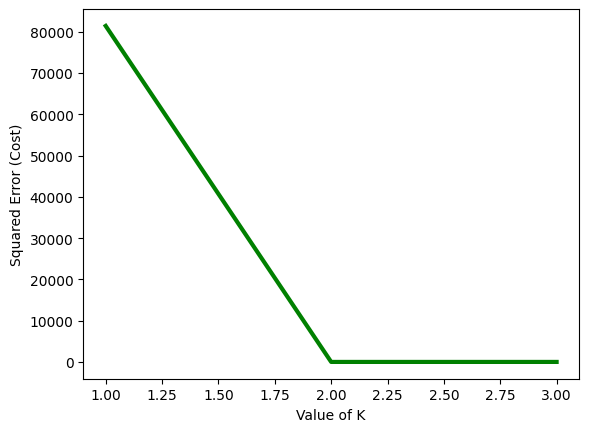

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

X = pd.DataFrame([[0,22],[0,22],[0,22],[0,255],[0,255],[0,255]])
cost =[]
for i in range(1, 4):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(X)

    # calculates squared error
    # for the clustered points
    cost.append(KM.inertia_)
    
# plot the cost against K values
plt.plot(range(1, 4), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.show() # clear the plot